# Step-6 Notebook for loading and evaluating the saved models

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model

In [4]:
# !pip install seaborn

In [5]:
import seaborn as sns

### Loading the training, validation and test dataset

In [6]:
import pickle
processed_training_data_path = "./flowcam_split_data/plankton_data_101x64_final.pkl"
#load corresponding class dict
class_dict = np.load("./flowcam_split_data/class_dict.npy",allow_pickle=True)
class_dict=dict(class_dict.tolist())
with open(processed_training_data_path, 'rb') as file:
    trainAttrX, valAttrX, testAttrX, trainImagesX, \
        valImagesX, testImagesX, y_train, y_val, y_test = pickle.load(file)

In [7]:
y=[np.where(r==1)[0][0] for r in y_train]

In [8]:
yv=[np.where(r==1)[0][0] for r in y_val]

In [9]:
yt=[np.where(r==1)[0][0] for r in y_test]

### Loading the trained model 

In [10]:
model=load_model("./trained_models/cnn3_with_aug_model.h5")

2024-08-14 16:52:29.695856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 16:52:31.382962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30965 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:86:00.0, compute capability: 7.0
2024-08-14 16:52:31.386679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30965 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:89:00.0, compute capability: 7.0


In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 101, 64, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 101, 64, 64)  9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 101, 64, 64)  256        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                            

In [12]:
testImagesX.shape

(23, 101, 64, 3)

### Running the predictions

In [13]:
"""for fusion model comment out #1 and uncomment #2 below for Fusion model"""
y_pred=model.predict(testImagesX) #1
# y_pred=model.predict([testImagesX,testAttrX]) #2

2024-08-14 16:52:33.545349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 3s 3s/step


In [14]:
y_pred1=[np.where(i==max(i))[0][0] for i in y_pred]
y_test1=[np.where(i==max(i))[0][0] for i in y_test]

### Generate classification report

In [15]:
report_dict = classification_report(y_test1, y_pred1, zero_division=1,output_dict=True)
# Convert the dictionary to a DataFrame
report_df = pd.DataFrame.from_dict(report_dict).transpose()

In [16]:
report_df

,precision,recall,f1-score,support
0,0.260870,1.00000,0.413793,6.00000
1,1.000000,0.00000,0.000000,6.00000
2,1.000000,0.00000,0.000000,3.00000
3,1.000000,0.00000,0.000000,8.00000
accuracy,0.260870,0.26087,0.260870,0.26087
macro avg,0.815217,0.25000,0.103448,23.00000
weighted avg,0.807183,0.26087,0.107946,23.00000


In [17]:
# !pip install openpyxl

In [18]:
 # Excluding 'accuracy', 'macro avg', 'weighted avg'
df2=report_df[:-3]
# sort_values(by="index").plot(x='index',y='recall')

In [19]:
df2.index=df2.index.astype(int)

In [20]:
df2=df2.astype(float)

In [21]:
set(df2.index.values).__len__()

4

In [22]:
df2

,precision,recall,f1-score,support
0,0.26087,1.0,0.413793,6.0
1,1.00000,0.0,0.000000,6.0
2,1.00000,0.0,0.000000,3.0
3,1.00000,0.0,0.000000,8.0


### Generating the bar chart showing sorted F1 score vs category performance of model

In [23]:
support_max=df2.support.max()
print('support',support_max)
print('total_samples',df2.support.sum())

support 8.0
total_samples 23.0


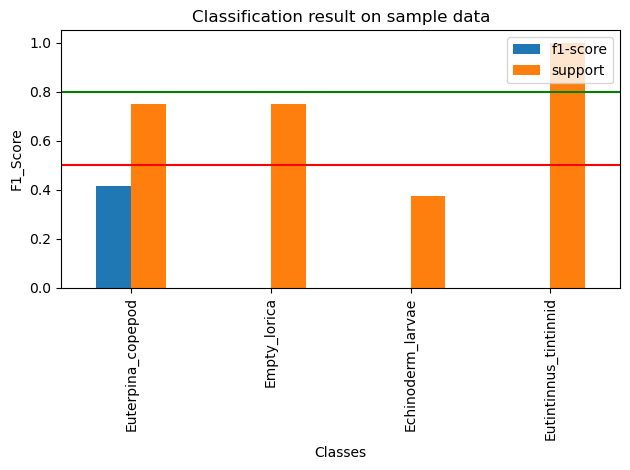

In [24]:
df2['categories']=df2.index.map(lambda x:class_dict[x] )
ind=df2.sort_values(by=['f1-score'],ascending=False).index
labels=[class_dict[i] for i in ind]
fig,ax=plt.subplots()
# ['index', 'precision', 'recall', 'f1-score', 'support']
df3=df2.drop(columns=['recall','precision'],axis=1).\
sort_values(by=['f1-score'],ascending=False) 
df3.support=df3.support/support_max
df3.plot(kind='bar',ax=ax)#,color=['r','b'])#, figsize=figsize)
plt.title('Classification result on sample data')
plt.axhline(.5,color='r')
plt.axhline(.8,color='g')
plt.xlabel('Classes')
plt.ylabel('F1_Score')
# locs, labels = plt.xticks()
plt.xticks(range(len(labels)),labels=df3.categories)#,rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
# plt.savefig("./first_draft/cnn_flowcam/classification_test_summary_flowcam_cnn.png")
plt.show()

In [25]:
# Store the classification results
# df2.to_excel("./results/classification_report_test_with_cat_flowcam_cnn.xlsx")
# df3.to_excel("./results/classification_report_test_sorted_with_cat_flowcam_cnn.xlsx")

In [26]:
repo_df=df2
repo_dfs=repo_df.sort_values(by='f1-score',ascending=False)
less_than=repo_dfs[repo_dfs['f1-score']<.5].index.astype(int)

In [27]:
len([class_dict[i] for i in less_than])

4

### Generating the confusion matrix for categories with F1 score less than 0.5

In [28]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test1, y_pred1,labels=np.unique(yt))

In [29]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [30]:
conf_matrix_df=pd.DataFrame(conf_matrix_normalized, index=np.unique(yt), columns=np.unique(yt))

In [31]:
conf_matrix_df=conf_matrix_df.loc[repo_dfs[repo_dfs['f1-score']<.5].index.astype(int),:]

In [32]:
conf_matrix_df

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0


In [33]:
conf_matrix_df.index=[class_dict[x] for x in conf_matrix_df.index.values]
conf_matrix_df.columns=[class_dict[x] for x in conf_matrix_df.columns.values]

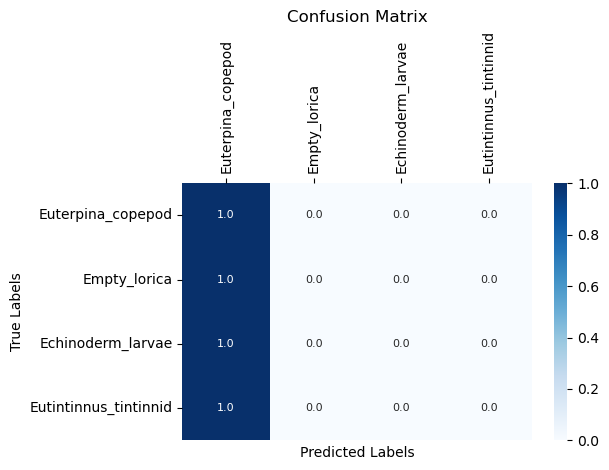

In [34]:
plt.figure()
heatmap=sns.heatmap(conf_matrix_df, fmt=".1f", cmap="Blues",annot=True,annot_kws={"size": 8})
heatmap.xaxis.tick_top()
heatmap.tick_params(axis='x', rotation=90)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
# plt.savefig('/lustre_scratch/prabgithub/test_folder/flowcam_test/codes_folder/first_draft/cnn_flowcam/confusionmatrix_F1_less_than_05.png')